PyMC Labs is excited to announce the release of [PyMC-Marketing](https://github.com/pymc-labs/pymc-marketing), an open-source Python package for statistical models of marketing processes.

Developed by a team of PyMC Labs researchers and community experts, PyMC-Marketing provides a user-friendly API for working with two key types of models: Media Mix and Customer Lifetime Value.

[Media Mix](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/)  models help optimize marketing spending by estimating the contribution of different media channels to overall sales. PyMC-Marketing's Media Mix models can account for the diminishing returns of ad exposure over time, and the impact of different channel saturation points.

[Customer Lifetime Value](https://en.wikipedia.org/wiki/Customer_lifetime_value)  models are used to predict future purchases and quantify the long-term value of a customer to a business. PyMC-Marketing's Customer Lifetime Value module includes a range of models, such as the Beta-Geometric/NBD,  Pareto/NBD (coming soon), and Gamma-Gamma models, to estimate churn rate, purchase frequency and monetary value of customers.

Although CLV and MMM are often treated separately in the literatarue, we believe that employnig them side-by-side can provide a more complete picture on the short-and-long return on investment of marketing activities. That's why both submodules can be found in pymc-marketing.

All models are implemented on top of [PyMC](https://www.pymc.io/welcome.html), the popular Bayesian statistical modeling package, and offer a principled approach to handling uncertainty, enabling robust decision-making.


## How to get started

If you want to give it a try, simply install PyMC according to the official [installation guidelines](https://www.pymc.io/projects/docs/en/stable/installation.html), then install PyMC-Marketing using pip.

```bash
conda install -c conda-forge pymc>5.0
pip install pymc-marketing
```

## Working with Media Mix Models

The following pseudo-code snippets illustrate how MMMs are specified in PyMC-Marketing.
You can find the real extended example in the [MMM example notebook](https://pymc-marketing.readthedocs.io/en/stable/notebooks/mmm/mmm_example.html).

We follow closely the model specification described in Google's seminal paper Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017). https://research.google/pubs/pub46001/

Concretely, we model a time series target variable (e.g. sales or conversions), by regressing on a special transformation of media variables (e.g. impressions, clicks or costs) and a set of control covariates (e.g. holidays, special events). The transformations used can mimic adstock (carry-over) and saturation effects commonly observed in media marketing scenarios.

In [1]:
# Hide code
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
import pandas
import arviz as az

Our example synthetic dataset includes weekly measurements spanning a period of 3 years. We observe a target variable `y`, and measure media variables from two channels `x1` and `x2`. Our covariates include two categorical events `event_1` and `event_2` and linear and periodic features extracted from the time components `[t:cos_order_2]`. 

In [2]:
data = pandas.read_csv("../../../datasets/mmm_example.csv", parse_dates=['date_week'])
data

,date_week,y,x1,x2,event_1,event_2,dayofyear,t,sin_order_1,cos_order_1,sin_order_2,cos_order_2
0,2018-04-02,3984.662237,0.318580,0.000000,0.0,0.0,92,0,0.999930,-0.011826,-0.023651,-0.999720
1,2018-04-09,3762.871794,0.112388,0.000000,0.0,0.0,99,1,0.991269,-0.131859,-0.261414,-0.965227
2,2018-04-16,4466.967388,0.292400,0.000000,0.0,0.0,106,2,0.968251,-0.249981,-0.484089,-0.875019
3,2018-04-23,3864.219373,0.071399,0.000000,0.0,0.0,113,3,0.931210,-0.364483,-0.678820,-0.734304
4,2018-04-30,4441.625278,0.386745,0.000000,0.0,0.0,120,4,0.880683,-0.473706,-0.834370,-0.551205
...,...,...,...,...,...,...,...,...,...,...,...,...
174,2021-08-02,3553.546148,0.033024,0.000000,0.0,0.0,214,174,-0.513901,-0.857849,0.881699,0.471812
175,2021-08-09,5565.509682,0.165615,0.863349,0.0,0.0,221,175,-0.613230,-0.789905,0.968786,0.247898
176,2021-08-16,4137.651485,0.171882,0.000000,0.0,0.0,228,176,-0.703677,-0.710520,0.999953,0.009676
177,2021-08-23,4479.041351,0.280257,0.000000,0.0,0.0,235,177,-0.783934,-0.620844,0.973402,-0.229104


In [3]:
from pymc_marketing import mmm

model = mmm.DelayedSaturatedMMM(
    data_df=data,
    target_column="y",
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
        "sin_order_1",
        "cos_order_1",
        "sin_order_2",
        "cos_order_2",
    ],
    adstock_max_lag=8,
)

These few lines are nough to define the highly structured Media Mix statistical model. 
We can obtain a graphical rendition of the model, which highlights the dimensions and data dependencies between the model parameters and data variables.

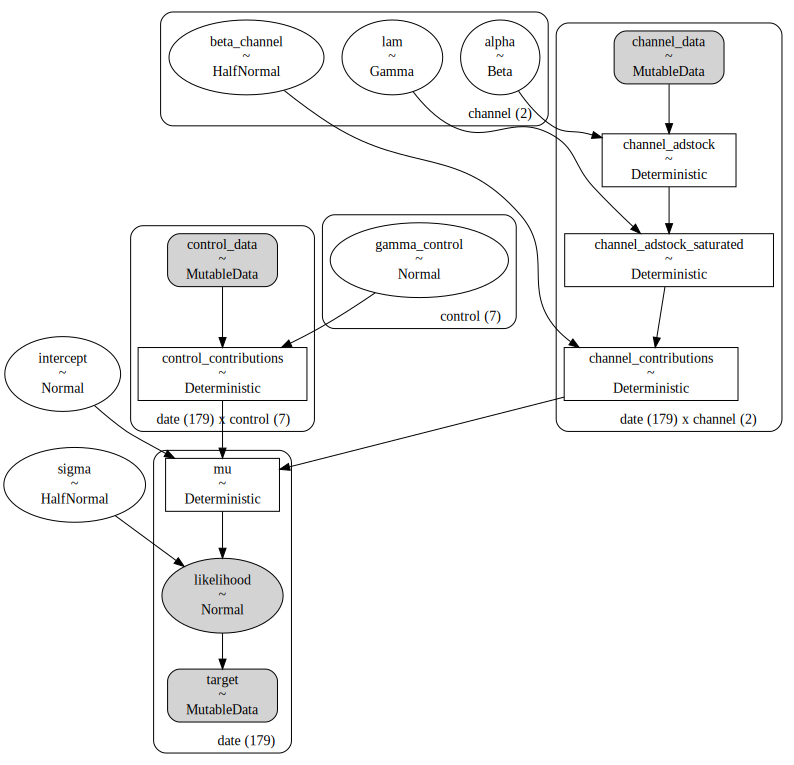

In [4]:
model.graphviz()

Once defined, we can fit the model to obtain plausible estimates for quantities of interest.

In [5]:
# Hide output
model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 133 seconds.
Sampling: [likelihood]


The plot below shows the estimated Returns on Ad Spend (ROAS) for the two channels `x1` and `x2` in the synthethic dataset from our example.
There is some inferential uncertainty about the exact ROAS of `x1`, but it is unambiguously higher than that of `x2`.

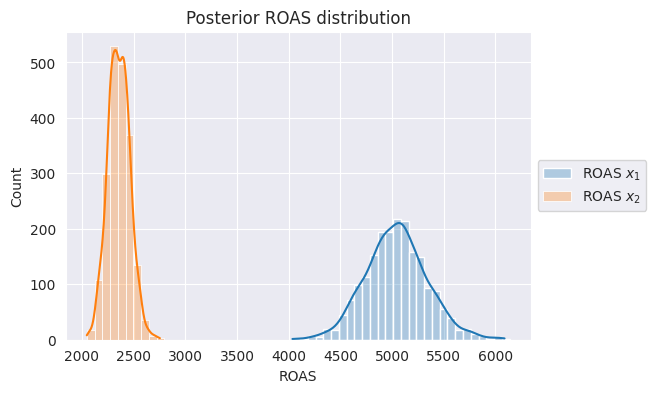

In [6]:
# Hide code
import matplotlib.pyplot as plt
import seaborn as sns

channel_contribution_original_scale = model.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / data[["x1", "x2"]].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(
    roas_samples.sel(channel="x1").to_numpy(), 
    alpha=0.3, 
    kde=True, 
    ax=ax, 
    label=r"ROAS $x_{1}$",
    stat="count",
    binwidth=75,
)
sns.histplot(
    roas_samples.sel(channel="x2").to_numpy(), 
    alpha=0.3,
    kde=True, 
    ax=ax, 
    label=r"ROAS $x_{2}$",
    binwidth=75,
    stat="count",
)
# ax.axvline(x=roas_1, color="C0", linestyle="--", label=r"true ROAS $x_{1}$")
# ax.axvline(x=roas_2, color="C1", linestyle="--", label=r"true ROAS $x_{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

The helper `plot_components_contributions` displays how much each component of the model contributes to the total observed sales over time.

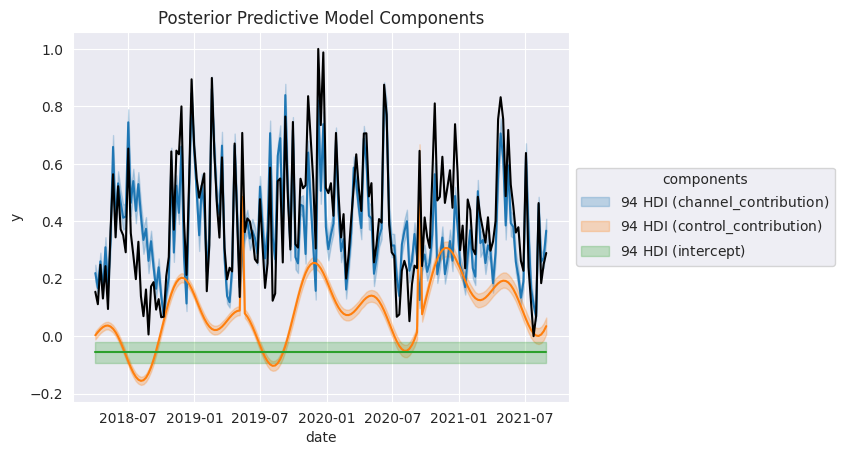

In [7]:
model.plot_components_contributions();

MMM classes include other useful utility plots (e.g. cost curves), diagnostic and summary methods. 
Many more still being planned. 

It is also easy to create custom analysis and visualization by using the fitted parameters and underlying PyMC model directly.

### Working with Customer Lifetime Value Models

The PyMC-Marketing CLV submodule is a spiritual successor to the [lifetimes](https://lifetimes.readthedocs.io/en/latest/) package, 
and offers most of the same models with a similar API. 

The following is a series of pseudo-code snippets of how CLV models are specified in PyMC-Marketing.
You can find the real extended example in the [CLV quickstart notebook](https://pymc-marketing.readthedocs.io/en/stable/notebooks/clv/clv_quickstart.html).

We use the `cdnow` ecommerce provider dataset included in the lifetimes package, to analyze customers’ repeat purchases. 

Each row of the dataset includes summary information for a single customer. 
* The `frequency` column specifies the  number of repeat purchases.
* The `recency` column tells us the timepoint at which the customer made their last purchase.
* The `T` column tells us how long ago did the customer do their first purchase.
* The `monetary_value` column contains the average spend of the customer across all their purchases.


In [8]:
data = pandas.read_csv("../../../datasets/clv_quickstart.csv")
data

,frequency,recency,T,monetary_value
0,2,30.43,38.86,22.35
1,1,1.71,38.86,11.77
2,0,0.00,38.86,0.00
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
...,...,...,...,...
2352,0,0.00,27.00,0.00
2353,5,24.29,27.00,44.93
2354,0,0.00,27.00,0.00
2355,4,26.57,27.00,33.32


We implement the Beta Geo Model also known as the BG/NBD model, described in Fader, P. S., Hardie, B. G., & Lee, K. L. (2005). “Counting your customers” the easy way: An alternative to the Pareto/NBD model. Marketing science, 24(2), 275-284.

This model estimates the probability that each customer is still "alive" at a given time, together with their average purchase frequency.

In [9]:
# Hide output
from pymc_marketing import clv

beta_geo_model = clv.BetaGeoModel(
    customer_id=data.index, 
    frequency=data["frequency"],
    recency=data["recency"], 
    T=data["T"],
)

beta_geo_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, alpha, r]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.


Inference data with groups:
	> posterior
	> sample_stats

Once fitted, we can use the model to predict the number of future purchases for known customers, as well as the probability that they are still alive.

In [10]:
# Hide output
beta_geo_model.expected_num_purchases(
    customer_id=data.index,
    # Predict purchases during the next 50 time periods
    t=50,
    frequency=data["frequency"], 
    recency=data["recency"], 
    T=data["T"]
)

<xarray.DataArray (chain: 2, draw: 1000, customer_id: 2357)>
array([[[1.52901467, 0.25776111, 0.24113343, ..., 0.31932783,
         4.25799174, 0.31932783],
        [1.47674748, 0.22608642, 0.25497742, ..., 0.33558586,
         4.21167163, 0.33558586],
        [1.49698034, 0.23899394, 0.22816554, ..., 0.30183056,
         4.24392297, 0.30183056],
        ...,
        [1.38335619, 0.27983591, 0.24407867, ..., 0.32139457,
         3.40622279, 0.32139457],
        [1.53702763, 0.33521433, 0.26840196, ..., 0.35449866,
         3.87946133, 0.35449866],
        [1.52374908, 0.26585418, 0.24221883, ..., 0.32204086,
         4.08387022, 0.32204086]],

       [[1.55222023, 0.24534993, 0.23737133, ..., 0.31318801,
         4.48635164, 0.31318801],
        [1.5362371 , 0.2418878 , 0.23676676, ..., 0.31254665,
         4.42491067, 0.31254665],
        [1.5387107 , 0.21934035, 0.23313782, ..., 0.30795952,
         4.51977339, 0.30795952],
        ...,
        [1.43776916, 0.28347305, 0.25482818, ..., 0.33509911,
         3.73680848, 0.33509911],
        [1.48040723, 0.28031681, 0.26848872, ..., 0.35274251,
         3.97188812, 0.35274251],
        [1.48040723, 0.28031681, 0.26848872, ..., 0.35274251,
         3.97188812, 0.35274251]]])
Coordinates:
  * chain        (chain) int64 0 1
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * customer_id  (customer_id) int64 0 1 2 3 4 5 ... 2352 2353 2354 2355 2356

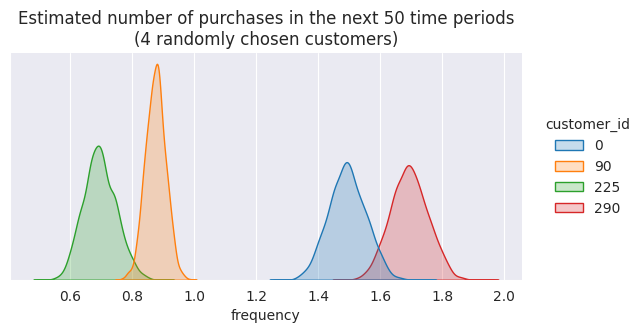

In [11]:
# Hide code
show_ids = [0, 90, 225, 290]
result = beta_geo_model.expected_num_purchases(
    customer_id=data.index,
    t=50,  # Predict purchases during the next time period
    frequency=data["frequency"], 
    recency=data["recency"], 
    T=data["T"],
)
x = result.isel(customer_id=show_ids).stack(sample=("chain", "draw"))
df = x.to_dataframe(name="frequency", dim_order=("customer_id", "sample"))
sns.displot(
    data=df, 
    x="frequency", 
    hue="customer_id", 
    kind="kde", 
    fill=True, 
    height=3, 
    aspect=2, 
    palette="tab10",
)
plt.title("Estimated number of purchases in the next 50 time periods\n(4 randomly chosen customers)")
plt.yticks([])
plt.ylabel(None);

The plot shows that customer 0 and 290 are expected to purchase twice as often than customers 90 and 225, over the next 50 time periods. This estimate takes into consideration the probability that customers dropped out, so let's look at that next.

In [12]:
# Hide output
beta_geo_model.expected_probability_alive(
    customer_id=data.index,
    frequency=data["frequency"], 
    recency=data["recency"], 
    T=data["T"]
)

<xarray.DataArray (chain: 2, draw: 1000, customer_id: 2357)>
array([[[0.73257814, 0.2165425 , 1.        , ..., 1.        ,
         0.86740151, 1.        ],
        [0.71204891, 0.19064417, 1.        , ..., 1.        ,
         0.86265055, 1.        ],
        [0.72248779, 0.20350341, 1.        , ..., 1.        ,
         0.86518271, 1.        ],
        ...,
        [0.71111752, 0.24351302, 1.        , ..., 1.        ,
         0.82369391, 1.        ],
        [0.75088054, 0.27932723, 1.        , ..., 1.        ,
         0.85605614, 1.        ],
        [0.73474214, 0.22256529, 1.        , ..., 1.        ,
         0.85803455, 1.        ]],

       [[0.73500224, 0.20627738, 1.        , ..., 1.        ,
         0.88072822, 1.        ],
        [0.73066372, 0.20384806, 1.        , ..., 1.        ,
         0.87652091, 1.        ],
        [0.7262629 , 0.18444872, 1.        , ..., 1.        ,
         0.8792899 , 1.        ],
        ...,
        [0.71986848, 0.24289698, 1.        , ..., 1.        ,
         0.8426474 , 1.        ],
        [0.72550974, 0.23630229, 1.        , ..., 1.        ,
         0.85548093, 1.        ],
        [0.72550974, 0.23630229, 1.        , ..., 1.        ,
         0.85548093, 1.        ]]])
Coordinates:
  * customer_id  (customer_id) int64 0 1 2 3 4 5 ... 2352 2353 2354 2355 2356
  * chain        (chain) int64 0 1
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

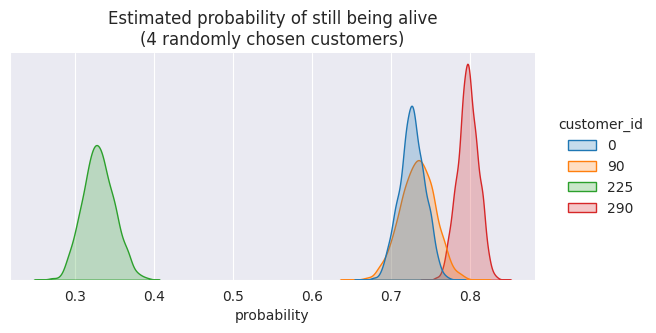

In [13]:
# Hide code
show_ids = [0, 90, 225, 290]
result = beta_geo_model.expected_probability_alive(
    customer_id=data.index,
    frequency=data["frequency"], 
    recency=data["recency"], 
    T=data["T"]
)
x = result.isel(customer_id=show_ids).stack(sample=("chain", "draw"))
df = x.to_dataframe(name="probability", dim_order=("customer_id", "sample"))
sns.displot(
    data=df,
    x="probability",
    hue="customer_id",
    kind="kde",
    fill=True,
    height=3,
    aspect=2,
    palette="tab10",
)
plt.title("Estimated probability of still being alive\n(4 randomly chosen customers)")
plt.yticks([])
plt.ylabel(None);

It seems customer 225 is likely to never purchase again from the ecommerce provider. 
That can explain the low expected number of purchases estimated above. 

The 3 other customers are still likely to be engaged with the service, although their rate of purchase is different. 
Specifically, as we saw above, customer 90 is deemed considerably less active.

We can also predict the expected purchase behavior for new customers that have not yet enrolled our service.

In [14]:
# Hide output
beta_geo_model.expected_num_purchases_new_customer(
    # Predict purchases during the next 50 time periods
    t=50,
)

<xarray.DataArray (chain: 2, draw: 1000)>
array([[1.44603663, 1.42446433, 1.36561508, ..., 1.27400752, 1.45098607,
        1.51878594],
       [1.37437932, 1.38090972, 1.40583687, ..., 1.32574174, 1.39707485,
        1.39707485]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

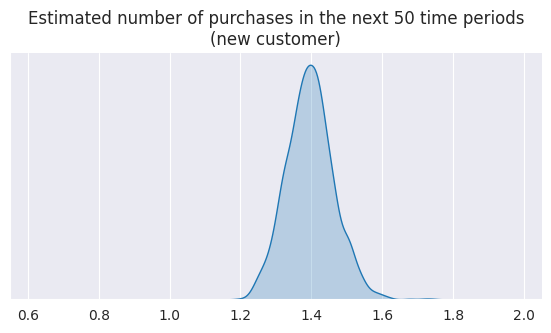

In [15]:
# Hide code
sns.displot(
    data=beta_geo_model.expected_num_purchases_new_customer(t=50).values.ravel(),
    kind="kde",
    fill=True,
    height=3,
    aspect=2,
)
plt.title("Estimated number of purchases in the next 50 time periods\n(new customer)")
plt.xlim([0.55, 2.05])
plt.yticks([])
plt.ylabel(None);

The BG/NBD model can be easily combined with the Gamma-Gamma model for monetary spending, also implemented in PyMC-Marketing.
Together, the two models provide estimates of customer lifetime, expected number of purchases and the average monetary value of each purchase. 
In other words: the lifetime value of a customer.

## Want to help?

We are on a journey to make Bayesian Media Mix and Customer Lifetime Value models more accessible and user-friendly to the marketing community.

PyMC-Marketing is still in its early stages of development, and we welcome feedback and contributions from the community.  Visit our [Github repository](https://github.com/pymc-labs/pymc-marketing) and get involved!